In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from os import listdir
from os.path import isfile, join
from scipy import stats
from skimage import io

# import sys
# sys.path.append('..')
# import src as tools

COLOR_MAP = {
    "light_orange": "#E69F00",
    "light_blue": "#56B4E9",
    "teal": "#009E73",
    "yellow": "#F0E442",
    "dark_blue": "#0072B2",
    "dark_orange": "#D55E00",
    "pink": "#CC79A7",
    "purple": "#9370DB",
    "black": "#000000",
    "silver": "#DCDCDC",
}

# 1. Load Data

Load 2019 and 2020 data.

In [2]:
df_2019 = pd.read_csv(f"../data/2024_04_12_parsed_2019_encoded.csv", index_col = 0)
df_2020 = pd.read_csv(f"../data/2024_04_12_parsed_2020_encoded.csv", index_col = 0)

df = pd.concat([df_2019, df_2020])
df.reset_index(drop = True, inplace = True)

for col in df.columns:
    if "date" in col:
        df[col] = pd.to_datetime(df[col])

print(f"{df.shape[0]} total entries.")

df.sort_values(by = ["date","pdf_page"], inplace = True)
df.reset_index(drop = True, inplace = True)

df["responding_units"] = df["responding_units"].replace({"37":"37k"})

21876 total entries.


# 2. Get Data Loss from Collection Step

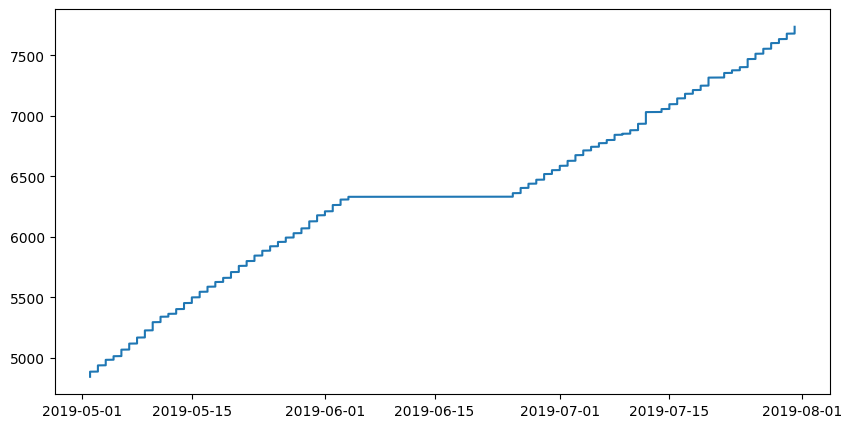

In [3]:
df_slice = df[(df["date"] <pd.to_datetime("2019-08-01"))&(df["date"] >pd.to_datetime("2019-05-01"))]
x = df_slice["date"].values
y = df_slice["date"].index


fig, ax = plt.subplots(figsize = (10,5))
ax.plot(x,y)

No records were provided for 2019-06-04 through 2019-06-24.  That's 21 days of missing records.

In [4]:
total_calls_2019 = 15973
avg_calls_per_day_2019 = df_2019.groupby("date")["change_idx"].count().mean()

missing_days_2019 = (pd.to_datetime("2019-06-25") - pd.to_datetime("2019-06-04")).days
missing_calls_2019 = int(missing_days_2019 * avg_calls_per_day_2019)
missing_pct_2019 = np.around(100 * missing_calls_2019/total_calls_2019, decimals = 2)
print(f"There are {missing_calls_2019} missing from the 2019 records request.")
print(f"That's a loss of {missing_pct_2019}%")

There are 878 missing from the 2019 records request.
That's a loss of 5.5%


In [5]:
total_calls_2020 = 10921
avg_calls_per_day_2020 = df_2020.groupby("date")["change_idx"].count().mean()

missing_days_2020 = (pd.to_datetime("2021-01-01") - df["date"].iloc[-1]).days
missing_calls_2020 = int(missing_days_2020 * avg_calls_per_day_2020)
missing_pct_2020 = np.around(100 * missing_calls_2020/total_calls_2020, decimals = 2)
print(f"There are {missing_calls_2020} missing from the 2020 records request.")
print(f"That's a loss of {missing_pct_2020}%")

There are 1929 missing from the 2020 records request.
That's a loss of 17.66%


In [6]:
df_log_count = pd.DataFrame(columns = [2019,2020])

# Total log count from Williamstown Annual Report.
df_log_count.loc["total_log_count"] = [total_calls_2019,total_calls_2020]

# Adjusted log count from records request.
foia_log_count_2019 = total_calls_2019 - missing_calls_2019
foia_log_count_2020 = total_calls_2020 - missing_calls_2020
df_log_count.loc["foia_log_count"] = [foia_log_count_2019,foia_log_count_2020]

df_log_count

,2019,2020
total_log_count,15973,10921
foia_log_count,15095,8992


# 3. Get Data Loss in Digitization Step

In [7]:
# Logs accounted for after OCR step.
ocr_log_count_2019 = df_2019.drop_duplicates("change_idx").shape[0]
ocr_log_count_2020 = df_2020.drop_duplicates("change_idx").shape[0]

df_log_count.loc["ocr_log_count"] = [ocr_log_count_2019,ocr_log_count_2020]

df_log_count

,2019,2020
total_log_count,15973,10921
foia_log_count,15095,8992
ocr_log_count,11459,7377


In [8]:
missing_calls_2019 = foia_log_count_2019 - df_log_count.loc["ocr_log_count",2019]
ocr_log_count_2019 = df_log_count.loc["ocr_log_count",2019]
missing_pct_2019 = np.around(100 * (foia_log_count_2019 - ocr_log_count_2019)/total_calls_2019, decimals = 2)

print(f"There are {missing_calls_2019} missing from the 2019 OCR step.")
print(f"That's an additional loss of {missing_pct_2019}%")

There are 3636 missing from the 2019 OCR step.
That's an additional loss of 22.76%


In [9]:
missing_calls_2020 = foia_log_count_2020 - df_log_count.loc["ocr_log_count",2020]
ocr_log_count_2020 = df_log_count.loc["ocr_log_count",2020]
missing_pct_2020 = np.around(100 * (foia_log_count_2020 - ocr_log_count_2020)/total_calls_2020, decimals = 2)

print(f"There are {missing_calls_2020} missing from the 2020 OCR step.")
print(f"That's an additional loss of {missing_pct_2020}%")

There are 1615 missing from the 2020 OCR step.
That's an additional loss of 14.79%


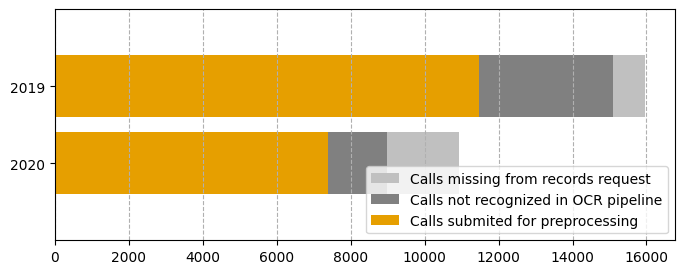

In [10]:
fig, ax = plt.subplots(figsize = (8,3))

width = df_log_count.loc["total_log_count"]
ax.barh(y = df_log_count.columns, 
        width = width, 
        label = "Calls missing from records request", 
        color = "silver",
        zorder = 1)

width = df_log_count.loc["foia_log_count"]
ax.barh(y = df_log_count.columns, 
        width = width, 
        label = "Calls not recognized in OCR pipeline", 
        color = "grey",
        zorder = 1)

width = df_log_count.loc["ocr_log_count"]
ax.barh(y = df_log_count.columns, 
        width = width, 
        label = "Calls submited for preprocessing",
        color = COLOR_MAP["light_orange"],
        zorder = 1)

ax.set_yticks([2019,2020])
ax.set_yticklabels([2019,2020])
ax.set_ylim(2021, 2018)
ax.xaxis.grid(True, linestyle = "--", zorder = 0)

plt.legend()
plt.show()

# 4. Process and Clean Data

In the section we'll deal with incorrect and missing data.   Before we start we want to get a general overview of data quality.

In [11]:
print(f"{df.shape[0]} entries remaining.")
print("")
print("Current Data Coverage: ")
df.count()/df.shape[0]*100

21876 entries remaining.

Current Data Coverage: 


date                100.000000
change_idx          100.000000
log_num             100.000000
pdf_page            100.000000
call_datetime        98.733772
call_reason         100.000000
call_type           100.000000
call_action         100.000000
call_taker          100.000000
street              100.000000
call_category       100.000000
responding_units     86.697751
disp_datetime        98.939477
clrd_datetime        77.057049
dtype: float64

Let's double check that the dates are in the correct order.  In the plot below, we expect to see a line that rises roughly diagonally from the lower left to the upper right.

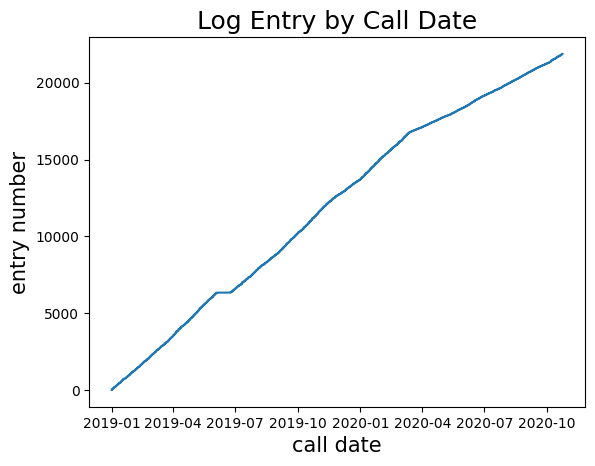

In [12]:
fig, ax = plt.subplots()
ax.plot(df["date"], df.index)
ax.set_xlabel("call date", fontsize = 15)
ax.set_ylabel("entry number", fontsize = 15)
ax.set_title("Log Entry by Call Date", fontsize = 18)
ax.set_xlim()
plt.show()

### Deal with Missing/Incorrect `call_datetime`.


In [13]:
df_timenans = df[(df["call_datetime"].isna())].copy()

df_timenans2019 = df_timenans[df_timenans["date"] < pd.to_datetime("2020-01-01")]
df_timenans2020 = df_timenans[df_timenans["date"] >= pd.to_datetime("2020-01-01")]

pct2019 = np.around(100 * df_timenans2019.shape[0]/df_log_count.loc["ocr_log_count",2019], decimals = 2)
print(f"There are {df_timenans2019.shape[0]} NaT datetimes in 2019.")
print(f"That's an additional {pct2019}% of all 2019 data.")
print("")
pct2020= np.around(100 * df_timenans2020.shape[0]/df_log_count.loc["ocr_log_count",2020], decimals = 2)
print(f"There are {df_timenans2020.shape[0]} NaT datetimes in 2020")
print(f"That's an additional {pct2020}% of all 2020 data.")


There are 256 NaT datetimes in 2019.
That's an additional 2.23% of all 2019 data.

There are 21 NaT datetimes in 2020
That's an additional 0.28% of all 2020 data.


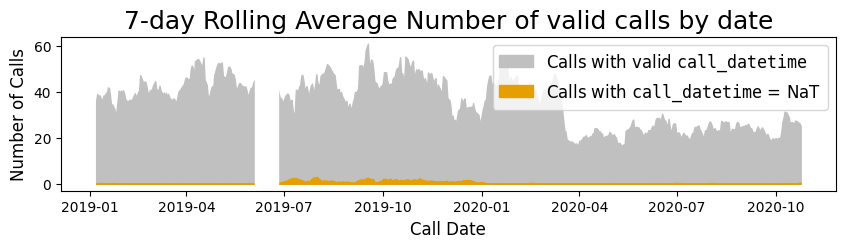

In [14]:
rolling_mean_total = df.groupby("date").count()["log_num"].rolling(7).mean()
rolling_mean_notnan = df.groupby("date").count()["call_datetime"].rolling(7).mean()
rolling_mean_nan = rolling_mean_total - rolling_mean_notnan

fig, ax = plt.subplots(figsize = (10,2))
ax.fill_between(x = rolling_mean_total.index, y1 = rolling_mean_total.values, 
                label = r"Calls with valid ${\tt call\_datetime}$", color = "silver")
ax.fill_between(x = rolling_mean_nan.index, y1 = rolling_mean_nan.values, 
                label = r"Calls with ${\tt call\_datetime}$ = NaT", color = COLOR_MAP["light_orange"])
ax.fill_between(x = [pd.to_datetime("2019-06-04"), pd.to_datetime("2019-06-25")],y1 = [60,60], color = "white")
ax.set_ylabel("Number of Calls", fontsize = 12)
ax.set_xlabel("Call Date", fontsize = 12)
plt.title("7-day Rolling Average Number of valid calls by date", fontsize = 18)
plt.legend(fontsize = 12)
plt.show()

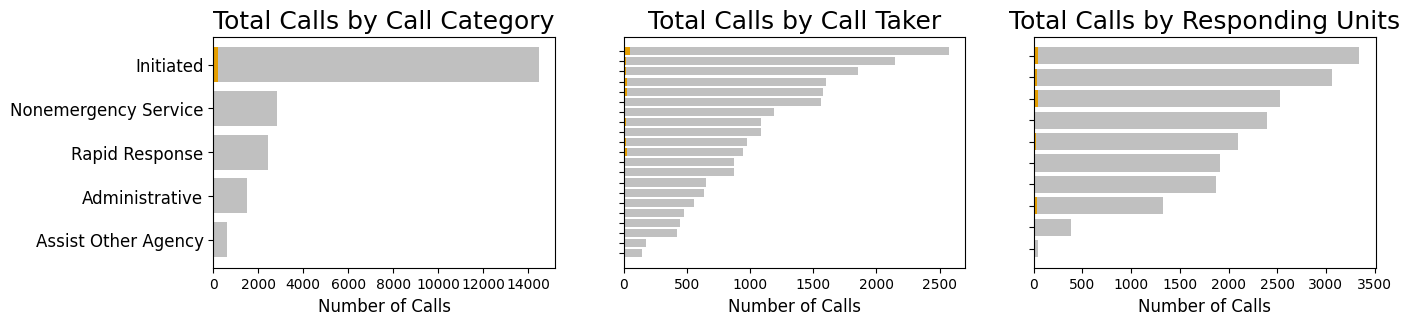

In [15]:
fig, ax = plt.subplots(1, 3, figsize = (15,3))

feature = "call_category"

df_valcount = pd.DataFrame(df.groupby(feature).count())
df_valcount.reset_index(inplace = True)
df_valcount.rename(columns = {"index":feature,"date":"count_total"}, inplace = True)
df_valcount = df_valcount[[feature,"count_total"]].copy()

df_valcount_nan = pd.DataFrame(df.groupby(feature).count())
df_valcount_nan.reset_index(inplace = True)
df_valcount_nan.rename(columns = {"index":feature,"call_datetime":"not_nan_total"}, inplace = True)
df_valcount_nan = df_valcount_nan[[feature,"not_nan_total"]].copy()

df_valcount_merged = df_valcount.merge(df_valcount_nan, how = "outer")
df_valcount_merged = df_valcount_merged.fillna(value = 0)
df_valcount_merged["nan_total"] = df_valcount_merged["count_total"] - df_valcount_merged["not_nan_total"]

df_valcount_merged.sort_values(by = "count_total", inplace = True)
df_valcount_merged.reset_index(drop = True, inplace = True)


ax[0].barh(df_valcount_merged[feature],df_valcount_merged["count_total"], color = "silver")
ax[0].barh(df_valcount_merged[feature],df_valcount_merged["nan_total"], color = COLOR_MAP["light_orange"])
ax[0].set_title("Total Calls by Call Category", fontsize = 18)
ax[0].set_xlabel("Number of Calls", fontsize = 12)
ax[0].set_yticks(df_valcount_merged[feature])
ax[0].set_yticklabels(df_valcount_merged[feature], fontsize = 12)

feature = "call_taker"

df_valcount = pd.DataFrame(df.groupby(feature).count())
df_valcount.reset_index(inplace = True)
df_valcount.rename(columns = {"index":feature,"date":"count_total"}, inplace = True)
df_valcount = df_valcount[[feature,"count_total"]].copy()

df_valcount_nan = pd.DataFrame(df.groupby(feature).count())
df_valcount_nan.reset_index(inplace = True)
df_valcount_nan.rename(columns = {"index":feature,"call_datetime":"not_nan_total"}, inplace = True)
df_valcount_nan = df_valcount_nan[[feature,"not_nan_total"]].copy()

df_valcount_merged = df_valcount.merge(df_valcount_nan, how = "outer")
df_valcount_merged = df_valcount_merged.fillna(value = 0)
df_valcount_merged["nan_total"] = df_valcount_merged["count_total"] - df_valcount_merged["not_nan_total"]

df_valcount_merged.sort_values(by = "count_total", inplace = True)
df_valcount_merged.reset_index(drop = True, inplace = True)


ax[1].barh(df_valcount_merged[feature],df_valcount_merged["count_total"], color = "silver")
ax[1].barh(df_valcount_merged[feature],df_valcount_merged["nan_total"], color = COLOR_MAP["light_orange"])
ax[1].set_yticklabels([])
ax[1].set_xlabel("Number of Calls", fontsize = 12)
ax[1].set_title("Total Calls by Call Taker", fontsize = 18)

feature = "responding_units"

df_valcount = pd.DataFrame(df.groupby(feature).count())
df_valcount.reset_index(inplace = True)
df_valcount.rename(columns = {"index":feature,"date":"count_total"}, inplace = True)
df_valcount = df_valcount[[feature,"count_total"]].copy()

df_valcount_nan = pd.DataFrame(df.groupby(feature).count())
df_valcount_nan.reset_index(inplace = True)
df_valcount_nan.rename(columns = {"index":feature,"call_datetime":"not_nan_total"}, inplace = True)
df_valcount_nan = df_valcount_nan[[feature,"not_nan_total"]].copy()

df_valcount_merged = df_valcount.merge(df_valcount_nan, how = "outer")
df_valcount_merged = df_valcount_merged.fillna(value = 0)
df_valcount_merged["nan_total"] = df_valcount_merged["count_total"] - df_valcount_merged["not_nan_total"]

df_valcount_merged.sort_values(by = "count_total", inplace = True)
df_valcount_merged.reset_index(drop = True, inplace = True)


ax[2].barh(df_valcount_merged[feature],df_valcount_merged["count_total"], 
           label = r"Calls with valid ${\tt call\_datetime}$", color = "silver")
ax[2].barh(df_valcount_merged[feature],df_valcount_merged["nan_total"], 
           label = r"Calls with ${\tt call\_datetime}$ = NaT", color = COLOR_MAP["light_orange"])
ax[2].set_yticklabels([])
ax[2].set_xlabel("Number of Calls", fontsize = 12)
ax[2].set_title("Total Calls by Responding Units", fontsize = 18)
#ax[2].legend(fontsize = 12, loc = "lower right", bbox_to_anchor = (1.1,0))

plt.show()

In [16]:
df = df[~df["call_datetime"].isna()].copy()

In [17]:
print(f"{df.shape[0]} entries remaining.")
print("")
print("Current Data Coverage: ")
df.count()/df.shape[0]*100

21599 entries remaining.

Current Data Coverage: 


date                100.000000
change_idx          100.000000
log_num             100.000000
pdf_page            100.000000
call_datetime       100.000000
call_reason         100.000000
call_type           100.000000
call_action         100.000000
call_taker          100.000000
street              100.000000
call_category       100.000000
responding_units     86.800315
disp_datetime       100.000000
clrd_datetime        77.281356
dtype: float64

In [18]:
#df.to_csv("../data/2024_04_08_df_for_ecological_inference.csv")

### Deal with Missing/Incorrect `clrd_datetime`.

A few things to note:

* `9-1-1 WRONG NUMBER` have no `clrd_datetime`.
* `PUBLIC RECORDS REQUEST` have no `clrd datetime`.
* `ALARM PERMIT RENEWAL` have no `clrd datetime`.
* `9-1-1 OVERFLOW NORTH ADAMS` have no `clrd datetime`.

In [19]:
prr_idx = np.where(df["call_reason"] == "PUBLIC RECORDS REQUEST")[0]

# df[df["call_reason"] == "PUBLIC RECORDS REQUEST"].loc[:,"clrd_datetime"] = pd.NaT
# df[df["call_reason"] == "9-1-1 WRONG NUMBER"].loc[:,"clrd_datetime"] = pd.NaT

df.loc[df.call_reason == "PUBLIC RECORDS REQUEST","clrd_datetime"] = pd.NaT
df.loc[df.call_reason == "9-1-1 WRONG NUMBER","clrd_datetime"] = pd.NaT
df.loc[df.call_reason == "ALARM PERMIT RENEWAL","clrd_datetime"] = pd.NaT
df.loc[df.call_reason == "9-1-1 OVERFLOW NORTH ADAMS","clrd_datetime"] = pd.NaT

In [20]:
df_timenans = df[df["clrd_datetime"].isna()].copy()

df_timenans2019 = df_timenans[df_timenans["date"] < pd.to_datetime("2020-01-01")]
df_timenans2020 = df_timenans[df_timenans["date"] >= pd.to_datetime("2020-01-01")]

pct2019 = np.around(100 * df_timenans2019.shape[0]/df_log_count.loc["ocr_log_count",2019], decimals = 2)
print(f"There are {df_timenans2019.shape[0]} NaT datetimes in 2019.")
print(f"That's {pct2019}% of all 2019 data.")
print("")

pct2020= np.around(100 * df_timenans2020.shape[0]/df_log_count.loc["ocr_log_count",2020], decimals = 2)
print(f"There are {df_timenans2020.shape[0]} NaT datetimes in 2020")
print(f"That's {pct2020}% of all 2020 data.")

There are 3213 NaT datetimes in 2019.
That's 28.04% of all 2019 data.

There are 1705 NaT datetimes in 2020
That's 23.11% of all 2020 data.


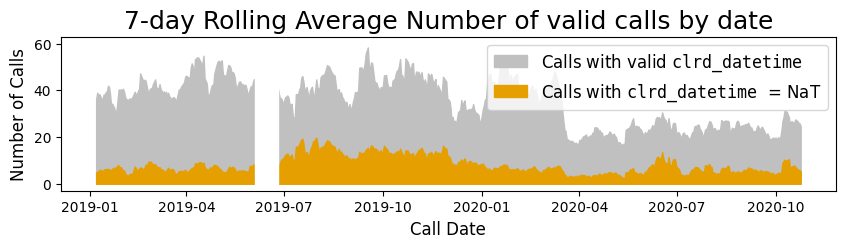

In [21]:
rolling_mean_total = df.groupby("date").count()["log_num"].rolling(7).mean()
rolling_mean_notnan = df.groupby("date").count()["clrd_datetime"].rolling(7).mean()
rolling_mean_nan = rolling_mean_total - rolling_mean_notnan

fig, ax = plt.subplots(figsize = (10,2))
ax.fill_between(x = rolling_mean_total.index, y1 = rolling_mean_total.values, 
                label = r"Calls with valid ${\tt clrd\_datetime}$", color = "silver")
ax.fill_between(x = rolling_mean_nan.index, y1 = rolling_mean_nan.values, 
                label = r"Calls with ${\tt clrd\_datetime}$  = NaT", color = COLOR_MAP["light_orange"])
ax.fill_between(x = [pd.to_datetime("2019-06-04"), pd.to_datetime("2019-06-25")],y1 = [60,60], color = "white")
ax.set_ylabel("Number of Calls", fontsize = 12)
ax.set_xlabel("Call Date", fontsize = 12)
plt.title("7-day Rolling Average Number of valid calls by date", fontsize = 18)
plt.legend(fontsize = 12)
plt.show()

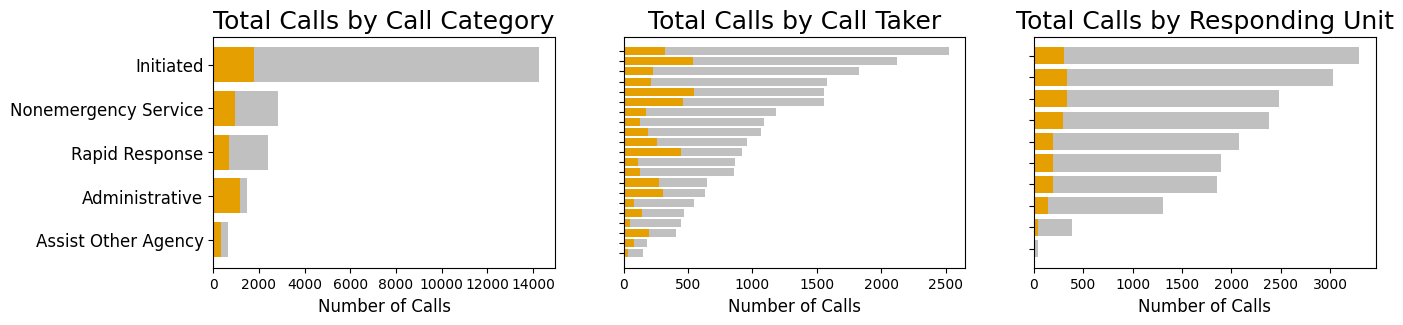

In [22]:
fig, ax = plt.subplots(1, 3, figsize = (15,3))

feature = "call_category"

df_valcount = pd.DataFrame(df.groupby(feature).count())
df_valcount.reset_index(inplace = True)
df_valcount.rename(columns = {"index":feature,"date":"count_total"}, inplace = True)
df_valcount = df_valcount[[feature,"count_total"]].copy()

df_valcount_nan = pd.DataFrame(df.groupby(feature).count())
df_valcount_nan.reset_index(inplace = True)
df_valcount_nan.rename(columns = {"index":feature,"clrd_datetime":"not_nan_total"}, inplace = True)
df_valcount_nan = df_valcount_nan[[feature,"not_nan_total"]].copy()

df_valcount_merged = df_valcount.merge(df_valcount_nan, how = "outer")
df_valcount_merged = df_valcount_merged.fillna(value = 0)
df_valcount_merged["nan_total"] = df_valcount_merged["count_total"] - df_valcount_merged["not_nan_total"]

df_valcount_merged.sort_values(by = "count_total", inplace = True)
df_valcount_merged.reset_index(drop = True, inplace = True)


ax[0].barh(df_valcount_merged[feature],df_valcount_merged["count_total"], color = "silver")
ax[0].barh(df_valcount_merged[feature],df_valcount_merged["nan_total"],color = COLOR_MAP["light_orange"])
ax[0].set_title("Total Calls by Call Category", fontsize = 18)
ax[0].set_xlabel("Number of Calls", fontsize = 12)
ax[0].set_yticks(df_valcount_merged[feature])
ax[0].set_yticklabels(df_valcount_merged[feature], fontsize = 12)

feature = "call_taker"

df_valcount = pd.DataFrame(df.groupby(feature).count())
df_valcount.reset_index(inplace = True)
df_valcount.rename(columns = {"index":feature,"date":"count_total"}, inplace = True)
df_valcount = df_valcount[[feature,"count_total"]].copy()

df_valcount_nan = pd.DataFrame(df.groupby(feature).count())
df_valcount_nan.reset_index(inplace = True)
df_valcount_nan.rename(columns = {"index":feature,"clrd_datetime":"not_nan_total"}, inplace = True)
df_valcount_nan = df_valcount_nan[[feature,"not_nan_total"]].copy()

df_valcount_merged = df_valcount.merge(df_valcount_nan, how = "outer")
df_valcount_merged = df_valcount_merged.fillna(value = 0)
df_valcount_merged["nan_total"] = df_valcount_merged["count_total"] - df_valcount_merged["not_nan_total"]

df_valcount_merged.sort_values(by = "count_total", inplace = True)
df_valcount_merged.reset_index(drop = True, inplace = True)

ax[1].barh(df_valcount_merged[feature],df_valcount_merged["count_total"], color = "silver")
ax[1].barh(df_valcount_merged[feature],df_valcount_merged["nan_total"], color = COLOR_MAP["light_orange"])
ax[1].set_yticklabels([])
ax[1].set_xlabel("Number of Calls", fontsize = 12)
ax[1].set_title("Total Calls by Call Taker", fontsize = 18)

feature = "responding_units"

df_valcount = pd.DataFrame(df.groupby(feature).count())
df_valcount.reset_index(inplace = True)
df_valcount.rename(columns = {"index":feature,"date":"count_total"}, inplace = True)
df_valcount = df_valcount[[feature,"count_total"]].copy()

df_valcount_nan = pd.DataFrame(df.groupby(feature).count())
df_valcount_nan.reset_index(inplace = True)
df_valcount_nan.rename(columns = {"index":feature,"clrd_datetime":"not_nan_total"}, inplace = True)
df_valcount_nan = df_valcount_nan[[feature,"not_nan_total"]].copy()

df_valcount_merged = df_valcount.merge(df_valcount_nan, how = "outer")
df_valcount_merged = df_valcount_merged.fillna(value = 0)
df_valcount_merged["nan_total"] = df_valcount_merged["count_total"] - df_valcount_merged["not_nan_total"]

df_valcount_merged.sort_values(by = "count_total", inplace = True)
df_valcount_merged.reset_index(drop = True, inplace = True)


ax[2].barh(df_valcount_merged[feature],df_valcount_merged["count_total"],  
           label = r"Calls with valid ${\tt clrd\_datetime}$",color = "silver")
ax[2].barh(df_valcount_merged[feature],df_valcount_merged["nan_total"],  
           label = r"Calls with ${\tt clrd\_datetime}$ = NaT", color = COLOR_MAP["light_orange"])
ax[2].set_yticklabels([])
ax[2].set_xlabel("Number of Calls", fontsize = 12)
ax[2].set_title("Total Calls by Responding Unit", fontsize = 18)
#ax[2].legend(fontsize = 12, loc = "lower right", bbox_to_anchor = (1.1,0)) 

plt.show()

In [23]:
df = df[~df["clrd_datetime"].isna()].copy()

Check where the difference between `call_datetime` and `clrd_datetime` are negative or really unreasonably long.

In [24]:
df["response_time_minutes"] = [d.total_seconds()/60 for d in df["clrd_datetime"] - df["call_datetime"]]

bad_response_times = df[df["response_time_minutes"] < 0].shape[0]
bad_response_pct = np.around(100 * bad_response_times/df.shape[0], decimals = 2)
long_response_times = df[df["response_time_minutes"] > 120].shape[0]
long_response_pct = np.around(100 * long_response_times/df.shape[0], decimals = 2)

print(f"* {bad_response_pct}% out of {df.shape[0]} entries with negative response time")
print(f"* {long_response_pct}% out of {df.shape[0]} entries with long response time")

* 2.17% out of 16681 entries with negative response time
* 7.03% out of 16681 entries with long response time


In [25]:
df = df[df["response_time_minutes"]>= 0].copy()

### Deal with Long Calls

In [26]:
df_long = df[df["response_time_minutes"] > 120].copy()

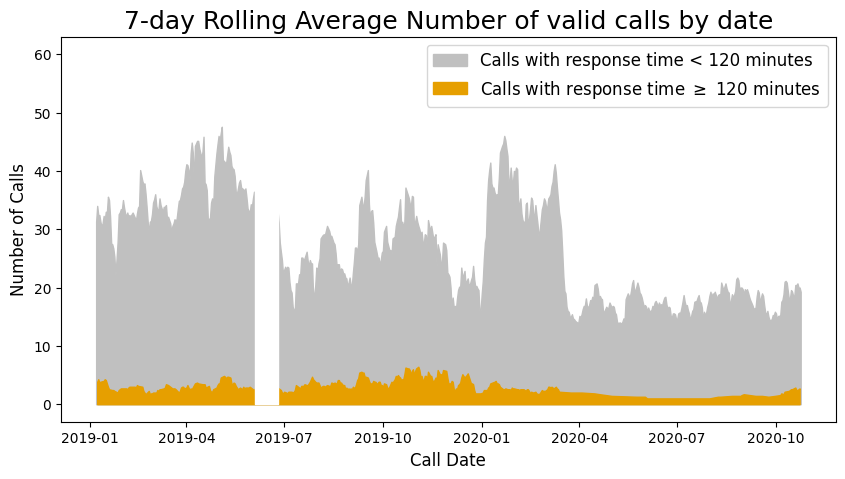

In [27]:
rolling_mean_total = df.groupby("date").count()["log_num"].rolling(7).mean()
rolling_mean_long = df_long.groupby("date").count()["log_num"].rolling(7).mean()


fig, ax = plt.subplots(figsize = (10,5))
ax.fill_between(x = rolling_mean_total.index, y1 = rolling_mean_total.values, 
                label = r"Calls with response time < 120 minutes", color = "silver")

ax.fill_between(x = rolling_mean_long.index, y1 = rolling_mean_long.values, 
                label = r"Calls with response time $\geq$ 120 minutes", color = COLOR_MAP["light_orange"])

ax.fill_between(x = [pd.to_datetime("2019-06-04"), pd.to_datetime("2019-06-25")],y1 = [60,60], color = "white")
ax.set_ylabel("Number of Calls", fontsize = 12)
ax.set_xlabel("Call Date", fontsize = 12)
plt.title("7-day Rolling Average Number of valid calls by date", fontsize = 18)
plt.legend(fontsize = 12)
plt.show()

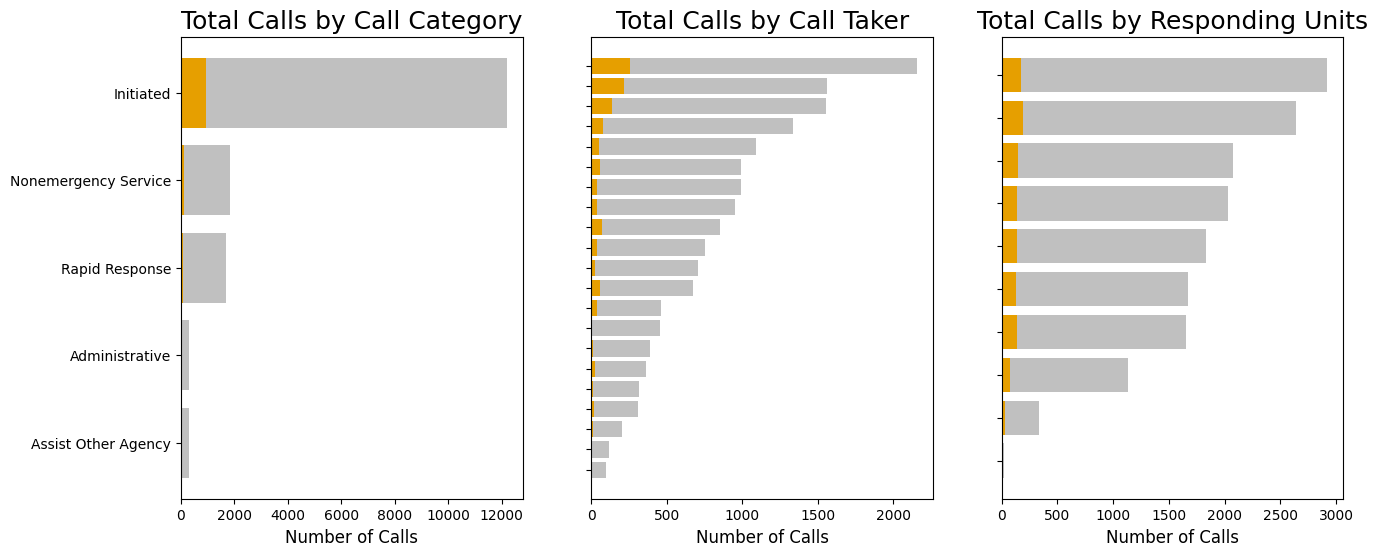

In [28]:
fig, ax = plt.subplots(1, 3, figsize = (15,6))

features = ["call_category","call_taker","responding_units"]
title = ["Call Category","Call Taker","Responding Units"]

for i, feature in enumerate(features):

    df_valcount = pd.DataFrame(df.groupby(feature).count())
    df_valcount.reset_index(inplace = True)
    df_valcount.rename(columns = {"index":feature,"date":"count_total"}, inplace = True)
    df_valcount = df_valcount[[feature,"count_total"]].copy()

    df_valcount_long = pd.DataFrame(df_long.groupby(feature).count())
    df_valcount_long.reset_index(inplace = True)
    df_valcount_long.rename(columns = {"index":feature,"clrd_datetime":"long_total"}, inplace = True)
    df_valcount_long = df_valcount_long[[feature,"long_total"]].copy()

    df_valcount_merged = df_valcount.merge(df_valcount_long, how = "outer")
    df_valcount_merged = df_valcount_merged.fillna(value = 0)

    df_valcount_merged.sort_values(by = "count_total", inplace = True)
    df_valcount_merged.reset_index(drop = True, inplace = True)

    ax[i].barh(df_valcount_merged[feature],df_valcount_merged["count_total"], color = "silver")
    ax[i].barh(df_valcount_merged[feature],df_valcount_merged["long_total"],color = COLOR_MAP["light_orange"])
    ax[i].set_title(f"Total Calls by {title[i]}", fontsize = 18)
    ax[i].set_xlabel("Number of Calls", fontsize = 12)
    
    if i > 0:
        ax[i].set_yticklabels([])


# 5. Get Data Loss from Validation Step

In [29]:
# Logs accounted for after processing.
count_2019 = len([d for d in df["date"] if d.year == 2019])
count_2020 = len([d for d in df["date"] if d.year == 2020])

df_log_count.loc["analysis_log_count"] = [count_2019, count_2020]
df_log_count

,2019,2020
total_log_count,15973,10921
foia_log_count,15095,8992
ocr_log_count,11459,7377
analysis_log_count,9857,6462


In [30]:
missing_calls_2019 = ocr_log_count_2019 - df_log_count.loc["analysis_log_count",2019]
analysis_log_count_2019 = df_log_count.loc["analysis_log_count",2019]
missing_pct_2019 = np.around(100 * (ocr_log_count_2019 - analysis_log_count_2019)/total_calls_2019, decimals = 2)

print(f"There are {missing_calls_2019} missing from the 2019 validation step.")
print(f"That's an additional loss of {missing_pct_2019}%")

There are 1602 missing from the 2019 validation step.
That's an additional loss of 10.03%


In [31]:
missing_calls_2020 = ocr_log_count_2020 - df_log_count.loc["analysis_log_count",2020]
analysis_log_count_2020 = df_log_count.loc["analysis_log_count",2020]
missing_pct_2020 = np.around(100 * (ocr_log_count_2020 - analysis_log_count_2020)/total_calls_2020, decimals = 2)

print(f"There are {missing_calls_2020} missing from the 2020 validation step.")
print(f"That's an additional loss of {missing_pct_2020}%")

There are 915 missing from the 2020 validation step.
That's an additional loss of 8.38%


In [32]:
df_preprocessing_stats = pd.DataFrame(columns = ["2019","2020"])
df_preprocessing_stats.loc["total_calls_analyzed"] = df_log_count.loc["analysis_log_count"].values
df_preprocessing_stats.loc["calls_dropped_for_quality_issues"] = (df_log_count.loc["ocr_log_count"] - df_log_count.loc["analysis_log_count"]).values
df_preprocessing_stats.loc["calls_not_read_by_OCR"] = (df_log_count.loc["foia_log_count"] - df_log_count.loc["ocr_log_count"]).values
df_preprocessing_stats.loc["calls_missing_from_records_request"] = (df_log_count.loc["total_log_count"] - df_log_count.loc["foia_log_count"]).values

print(df_preprocessing_stats.sum(axis = 0))

df_preprocessing_stats

2019    15973
2020    10921
dtype: int64


,2019,2020
total_calls_analyzed,9857,6462
calls_dropped_for_quality_issues,1602,915
calls_not_read_by_OCR,3636,1615
calls_missing_from_records_request,878,1929


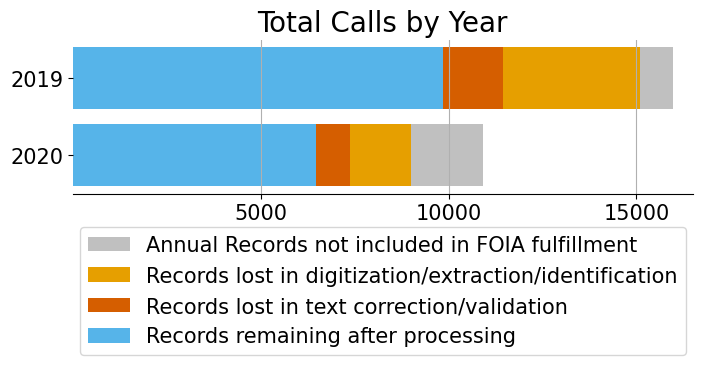

In [33]:
colors = ["silver", COLOR_MAP["light_orange"], COLOR_MAP["dark_orange"], 
          COLOR_MAP["light_blue"]]

labels = ["Annual Records not included in FOIA fulfillment",
         "Records lost in digitization/extraction/identification",
         "Records lost in text correction/validation",
         "Records remaining after processing"]

fig, ax = plt.subplots(figsize = (8,2))
for i, idx in enumerate(df_log_count.index):
    val_2019 = df_log_count.loc[idx,2019]
    val_2020 = df_log_count.loc[idx,2020]
    ax.barh(2019, val_2019, color = colors[i], label = labels[i])
    ax.barh(2020, val_2020, color = colors[i])
    
ax.legend(loc = "upper center", bbox_to_anchor = (.5,-.15), fontsize = 15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)

ax.set_xticks([5000, 10000,15000])
ax.set_xticklabels([5000, 10000,15000],fontsize = 15)
ax.set_xlim(0,16500)


ax.set_yticks([2019,2020])
ax.set_yticklabels([2019,2020],fontsize = 15)
ax.set_ylim(2020.5, 2018.5)

ax.xaxis.grid(True)


plt.title("Total Calls by Year", fontsize = 20)
plt.show()

plt.show()

In [34]:
print("Percentage lost in foia step:")
(df_log_count.loc["total_log_count",:] - df_log_count.loc["foia_log_count",:])/df_log_count.loc["total_log_count",:]

Percentage lost in foia step:


2019    0.054968
2020    0.176632
dtype: float64

In [35]:
print("Percentage lost in OCR step:")
(df_log_count.loc["foia_log_count",:] - df_log_count.loc["ocr_log_count",:])/df_log_count.loc["total_log_count",:]

Percentage lost in OCR step:


2019    0.227634
2020    0.147880
dtype: float64

In [36]:
print("Percentage lost in validation step:")
(df_log_count.loc["ocr_log_count",:] - df_log_count.loc["analysis_log_count",:])/df_log_count.loc["total_log_count",:]

Percentage lost in validation step:


2019    0.100294
2020    0.083784
dtype: float64

In [37]:
print("We've retained the following for analysis:")
df_log_count.loc["analysis_log_count",:]/df_log_count.loc["total_log_count",:]

We've retained the following for analysis:


2019    0.617104
2020    0.591704
dtype: float64

# 6. Preliminary Data Exploration

In [38]:
df["call_type"].value_counts()

call_type
Initiated    12023
Phone         2815
911            852
Walk-In        279
Other          233
Radio          117
Name: count, dtype: int64

Mean Response Time Initiated: 7.29
Mean Response Time Service Call: 21.21


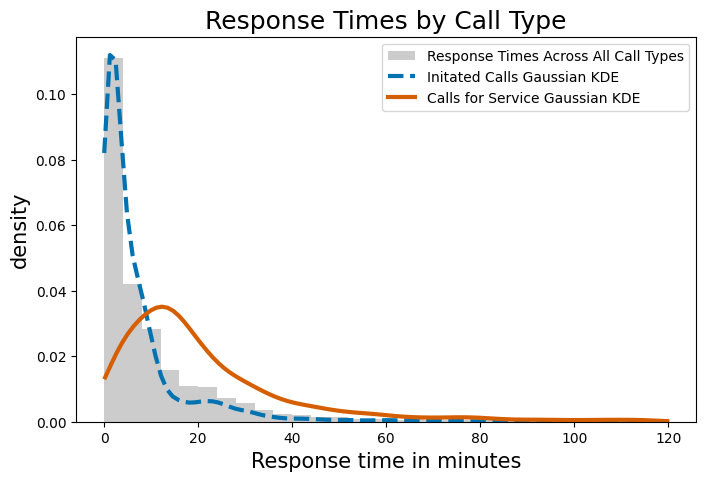

In [39]:
df_short = df[df["response_time_minutes"] <= 120].copy()
fig, ax = plt.subplots(figsize = (8,5))

y = df_short["response_time_minutes"]
ax.hist(y, bins = 30, density = True, color = "grey", alpha = .4,
       label = "Response Times Across All Call Types")

y = df_short[df_short["call_category"] == "Initiated"]["response_time_minutes"]
mrt = np.around(y.mean(), decimals = 2)
print(f"Mean Response Time Initiated: {mrt}")

kde = stats.gaussian_kde(y)
tt = np.linspace(y.min(), y.max(), 100)
ax.plot(tt, kde(tt), linewidth = 3, label = "Initated Calls Gaussian KDE", 
        color = COLOR_MAP["dark_blue"], linestyle = "--")

y = df_short[df_short["call_category"] != "Initiated"]["response_time_minutes"]
mrt = np.around(y.mean(), decimals = 2)
print(f"Mean Response Time Service Call: {mrt}")

kde = stats.gaussian_kde(y)
tt = np.linspace(y.min(), y.max(), 100)
ax.plot(tt, kde(tt), linewidth = 3, label = "Calls for Service Gaussian KDE", 
        color = COLOR_MAP["dark_orange"])

ax.set_xlabel("Response time in minutes", fontsize = 15)
ax.set_ylabel("density", fontsize = 15)


ax.set_title("Response Times by Call Type", fontsize = 18)

plt.legend()
plt.show()

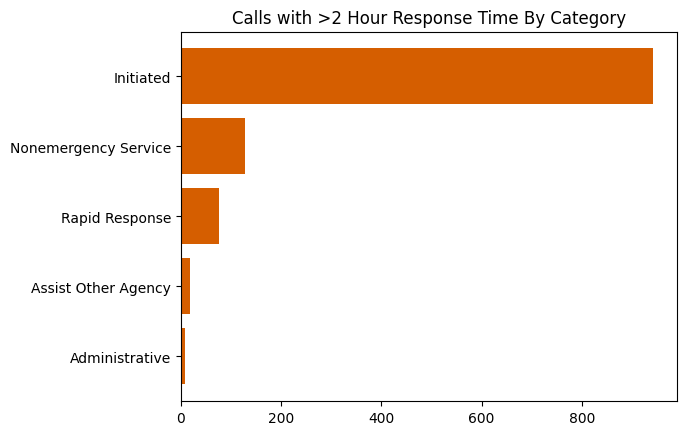

In [40]:
df_long = df[df["response_time_minutes"] > 120]

y = df_long["call_category"].value_counts(ascending = True).index
x = df_long["call_category"].value_counts(ascending = True).values
fig, ax = plt.subplots()
ax.barh(y,x, color = COLOR_MAP["dark_orange"])
ax.set_title("Calls with >2 Hour Response Time By Category")

plt.show()

In [41]:
count_2019 = len([d for d in df["date"] if d.year == 2019])
count_2020 = len([d for d in df["date"] if d.year == 2020])

In [42]:
# Logs accounted for after processing.
count_2019 = len([d for d in df["date"] if d.year == 2019])
count_2020 = len([d for d in df["date"] if d.year == 2020])
df_log_count.loc["analysis_log_count"] = [count_2019, count_2020]

print("Percentage of data lost in the processing step:")
100 * (df_log_count.loc["ocr_log_count",:] - df_log_count.loc["analysis_log_count",:])/df_log_count.loc["total_log_count",:]

Percentage of data lost in the processing step:


2019    10.029425
2020     8.378354
dtype: float64

In [43]:
print(f"{df.shape[0]} entries remaining.")
print("")
print("Current Data Coverage: ")
df.count()/df.shape[0]*100

16319 entries remaining.

Current Data Coverage: 


date                     100.0
change_idx               100.0
log_num                  100.0
pdf_page                 100.0
call_datetime            100.0
call_reason              100.0
call_type                100.0
call_action              100.0
call_taker               100.0
street                   100.0
call_category            100.0
responding_units         100.0
disp_datetime            100.0
clrd_datetime            100.0
response_time_minutes    100.0
dtype: float64

## Add call datetime hour, weekday, and month

In [44]:
df["hour"] = np.array([d.hour for d in df["disp_datetime"]])
df["weekday"] = np.array([d.weekday() for d in df["disp_datetime"]])
df["month"] = np.array([d.month for d in df["disp_datetime"]])

In [46]:
#df.to_csv("../data/df_for_response_time_modeling.csv")